#### Trénování modelů na základních datech

In [1]:
import pandas as pd
import numpy as np
import shap
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from webpages.preprocessing import Preprocessor, print_metrics

In [2]:
p = Preprocessor('data_2')
dataframes = p.get_dataframes()

In [3]:
address = dataframes['address']
company = dataframes['company']
contract_person = dataframes['contact_person']
contract_authority = dataframes['contracting_authority']
offer = dataframes['offer']
procurement = dataframes['procurement']

Příprava dat pro trénování modelu:

In [4]:
df_for_pred = offer.copy()
df_for_pred = pd.merge(df_for_pred, procurement, left_on='procurement_id', right_on='id', how='left')
df_for_pred['is_winner'] = (df_for_pred['company_id'] == df_for_pred['supplier_id'])

In [5]:
df_for_pred.drop(columns=['id_x', 'id_y', 'company_id', 'procurement_id', 'contact_person_id', 'procurement_name', 'name_from_nipez_codelist', 'system_number', 'contracting_authority_id', 'supplier_id' , 'contract_price', 'contract_price_vat',
'contract_price_with_amendments', 'contract_price_with_amendments_vat'], inplace=True)

In [6]:
df_for_pred.head(10)

,is_association_of_suppliers_x,is_rejected_due_too_low,is_withdrawn,price,price_vat,bids_submission_deadline,code_from_nipez_codelist,date_of_contract_close,date_of_publication,is_association_of_suppliers_y,place_of_performance,public_contract_regime,type,type_of_procedure,is_winner
0,True,False,False,0.00,0.00,NaN,15710000-8,2022-03-02,2022-03-02,False,Liberecký kraj,NaN,Public contract for deliveries,Zadávání VZ na základě rámcové dohody bez obno...,True
1,False,False,False,9832.02,11897.00,NaN,50110000-9,2023-11-23,2023-11-30,False,Jihočeský kraj,NaN,Public contract for services,Zadávání VZ na základě rámcové dohody bez obno...,True
2,False,False,False,130000.00,130000.00,NaN,NaN,2022-02-24,2022-03-02,False,NaN,Small-scale public contract,Public contract for deliveries,Otevřená výzva,True
3,True,False,False,0.00,0.00,NaN,90511000-2,2022-03-07,2022-03-07,False,Liberecký kraj,NaN,Public contract for services,Zadávání VZ na základě rámcové dohody bez obno...,True
4,False,False,False,8468.00,9314.80,NaN,90500000-2,2023-10-24,2023-10-24,False,Středočeský kraj,NaN,Public contract for services,Zadávání VZ na základě rámcové dohody bez obno...,True
5,False,False,False,90525.00,109535.25,NaN,24612000-7,2022-03-31,2022-04-01,False,Liberecký kraj,NaN,Public contract for services,Zadávání VZ na základě rámcové dohody bez obno...,True
6,False,False,False,0.00,0.00,NaN,15710000-8,2022-04-01,2022-04-01,False,Liberecký kraj,NaN,Public contract for deliveries,Zadávání VZ na základě rámcové dohody bez obno...,True
7,True,False,False,0.00,0.00,NaN,15710000-8,2022-04-28,2022-05-03,False,Liberecký kraj,NaN,Public contract for deliveries,Zadávání VZ na základě rámcové dohody bez obno...,True
8,False,False,False,130000.00,130000.00,NaN,03322000-2,2022-03-31,2022-04-21,False,NaN,Small-scale public contract,Public contract for deliveries,Otevřená výzva,True
9,False,False,False,NaN,NaN,2023-10-03,38434520-7,2023-11-08,2023-09-04,False,Jihomoravský kraj,Above-limit public contract,Public contract for deliveries,Otevřené řízení,False


Určení kategorických příznaků pro model CatBoost a nahrazení chybějících hodnot:

In [7]:
categ = ['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure', 'code_from_nipez_codelist','date_of_contract_close', 'bids_submission_deadline', 'date_of_publication']
for c in categ:
    df_for_pred[c].replace({np.nan : 'Unknown'}, inplace=True)

Odstranění řádků s chybějícími hodnotami:

In [8]:
df_for_pred.dropna(inplace=True)

Seřazení dat podle data publikace a rozdělení na validační data:

In [9]:
df_for_pred = df_for_pred.sort_values(by='date_of_publication')

In [10]:
train_data = df_for_pred.drop(columns=["is_winner"])
train_labels = df_for_pred["is_winner"]
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(train_data, train_labels, test_size=0.20, shuffle=False)

Natrénování základního modelu CatBoost:

In [11]:
model_with_price = CatBoostClassifier(iterations=10,
                           depth=7,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True,
                           cat_features=['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure', 'code_from_nipez_codelist','date_of_contract_close', 'date_of_publication', 'bids_submission_deadline'])
# train the model
model_with_price.fit(X_train_base, y_train_base)

0:	learn: 0.5405328	total: 238ms	remaining: 2.14s
1:	learn: 0.5161505	total: 342ms	remaining: 1.37s
2:	learn: 0.5074953	total: 423ms	remaining: 987ms
3:	learn: 0.5046557	total: 484ms	remaining: 726ms
4:	learn: 0.5019609	total: 556ms	remaining: 556ms
5:	learn: 0.4975908	total: 601ms	remaining: 401ms
6:	learn: 0.4950989	total: 648ms	remaining: 278ms
7:	learn: 0.4917350	total: 705ms	remaining: 176ms
8:	learn: 0.4901102	total: 753ms	remaining: 83.6ms
9:	learn: 0.4893927	total: 811ms	remaining: 0us


Metriky základního modelu CatBoost na validační množině:
Balanced accuracy: 0.7268023897658706
F1 score micro: 0.7256669398160794
F1 score macro: 0.7231655628643783
RocAuc score: 0.7937011191489565
Confusion matrix:


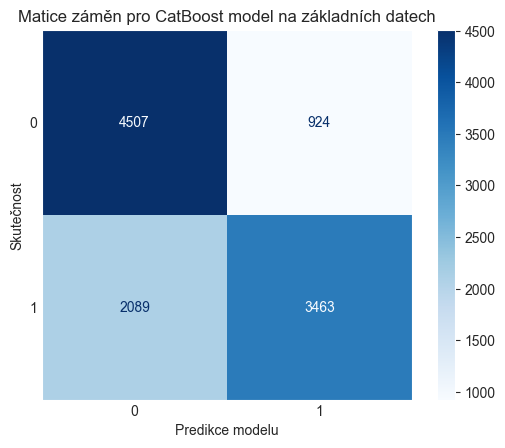

In [12]:
print("Metriky základního modelu CatBoost na validační množině:")
print_metrics(model_with_price, X_test_base, y_test_base, ptitle="Matice záměn pro CatBoost model na základních datech")

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
predictions = model_with_price.predict(X_test_base)
cm_catboost = confusion_matrix(y_test_base.astype("str"), predictions)

Zobrazení důležitosti příznaků:

In [15]:
importances_simple = model_with_price.get_feature_importance()
feature_importances_simple = pd.Series(importances_simple, index=X_test_base.columns).sort_values(ascending=False)
feature_importances_simple 

type_of_procedure                34.897792
code_from_nipez_codelist         15.980910
public_contract_regime           10.557039
place_of_performance              8.991075
price_vat                         8.117585
type                              7.380310
price                             3.110001
is_association_of_suppliers_x     2.688404
is_withdrawn                      2.553458
is_association_of_suppliers_y     2.545400
bids_submission_deadline          1.720144
date_of_publication               1.338343
is_rejected_due_too_low           0.119539
date_of_contract_close            0.000000
dtype: float64

Natrénování modelu logistické regrese:

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

Převedení kategorických příznaků na dummy proměnné:

In [18]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_base)
X_train_dummies = enc.transform(X_train_base)

In [19]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_dummies, y_train_base)

In [20]:
X_test_dummies = enc.transform(X_test_base)

Výpis metrik pro model logistické regrese:

Balanced accuracy: 0.7149194081155412
F1 score micro: 0.7141946644814714
F1 score macro: 0.7132330491860157
RocAuc score: 0.7824047309261539
Confusion matrix:


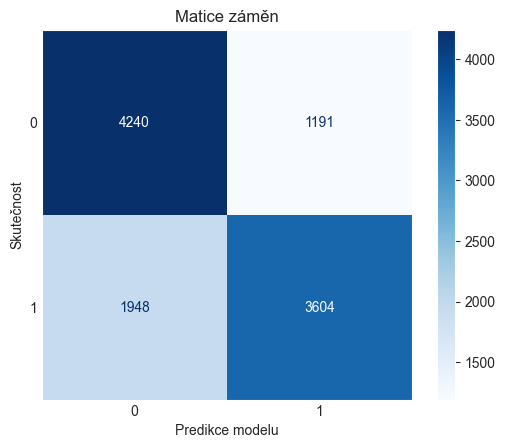

In [21]:
print_metrics(clf, X_test_dummies, y_test_base, retype_pred=True)